# 載入所需套件

In [1]:
import pandas as pd
import geopandas as gpd
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib inline

#設定字體和解決圖像中文顯示問題
plt.rcParams['font.sans-serif']=['Microsoft JhengHei']
plt.rcParams['axes.unicode_minus']=False

# 定義數據資料和地圖資料清理合併函數

In [2]:
def merge_df():
    #取得地圖資料
    city_shp=gpd.read_file('./縣市界線圖資/COUNTY_MOI_1080726.shp',encoding='utf-8')
    #爬取數值資料
    response=requests.get('https://www.dgbas.gov.tw/public/data/open/localstat/011-%E5%90%84%E7%B8%A3%E5%B8%82%E5%88%A5%E5%B9%B3%E5%9D%87%E6%AF%8F%E6%88%B6%E6%B6%88%E8%B2%BB%E6%94%AF%E5%87%BA.xml')
    response.encoding='utf-8'
    soup=BeautifulSoup(response.text,'html.parser')
    datas=soup.select('data')
    
    value_dfs,top5_dfs=[],[]
    
    for e in datas:
        countrynames,consumptions=[],[]
        
        split_list=e.text.replace('\r','').replace('\n','').replace('\t','').replace('<',' ').replace('>',' ').split()
        value_list=split_list[1:]
        year=split_list[0]
        years=[year]*(int(len(value_list)/2))

        for i in range(len(value_list)):
            if i%2==0:
                countrynames.append(value_list[i])
            else:
                consumptions.append(value_list[i])
        
        #將平均消費支出調整成數值形式
        consumptions=list(map(int,consumptions))
        
        value_df=pd.DataFrame({
            'YEAR':years,
            'COUNTYNAME':countrynames,
            'CONSUMPTION':consumptions
        })
        value_df.sort_values(by=['CONSUMPTION'],ascending=False,inplace=True)
        value_df.reset_index(drop=True,inplace=True)
        top5_df=value_df.iloc[:5,:]
        value_dfs.append(value_df)
        top5_dfs.append(top5_df)

    value_dfs=pd.concat(value_dfs,ignore_index=True)
    top5_dfs=pd.concat(top5_dfs,ignore_index=True)
    
    #合併數值資料和地圖資料
    merge_df=city_shp.merge(value_dfs,on='COUNTYNAME')
    top5_merge_df=city_shp.merge(top5_dfs,on='COUNTYNAME')
    top5_merge_df['centroid']=top5_merge_df['geometry'].centroid
    
    return value_dfs,top5_dfs,merge_df,top5_merge_df

# 定義繪製全台平均每戶消費支出地圖

In [3]:
def consumption_map(year):
    year_df=merge_df[merge_df['YEAR']==year]
    top5_year_df=top5_merge_df[top5_merge_df['YEAR']==year]
    
    vmin=year_df['CONSUMPTION'].min()
    vmax=year_df['CONSUMPTION'].max()
    sm=plt.cm.ScalarMappable(cmap='OrRd',norm=plt.Normalize(vmin=vmin,vmax=vmax))
    props=dict(boxstyle='round',facecolor='linen',alpha=0.9)

    fig,ax=plt.subplots(1,figsize=(25,25))
    year_df.plot(ax=ax,column='CONSUMPTION',edgecolor='k',cmap='OrRd')
    ax.set_xlim(119,122.5)
    ax.set_ylim(21.5,25.5)
    ax.set_title('{}年全台平均每戶消費支出前五名縣市'.format(year),fontsize=25)
    ax.axis('off')
    
    for point in top5_year_df.iterrows():
        ax.text(point[1]['centroid'].x,
                point[1]['centroid'].y,
                point[1]['COUNTYNAME']+'\n{}元'.format(point[1]['CONSUMPTION']),
                horizontalalignment='center',
                fontsize=12,
                bbox=props)  
    
    #解決色條棒圖形長度問題(size:寬度,pad:距離)
    divider=make_axes_locatable(ax)
    cax=divider.append_axes('right',pad=0.5,size='3%')

    cbar=plt.colorbar(sm,cax=cax)
    cbar.ax.set_title('(單位:元)',fontsize=18)

# 數據資料和地圖資料合併結果

In [4]:
value_dfs,top5_dfs,merge_df,top5_merge_df=merge_df()

# 繪製指定年份平均每戶消費支出地圖

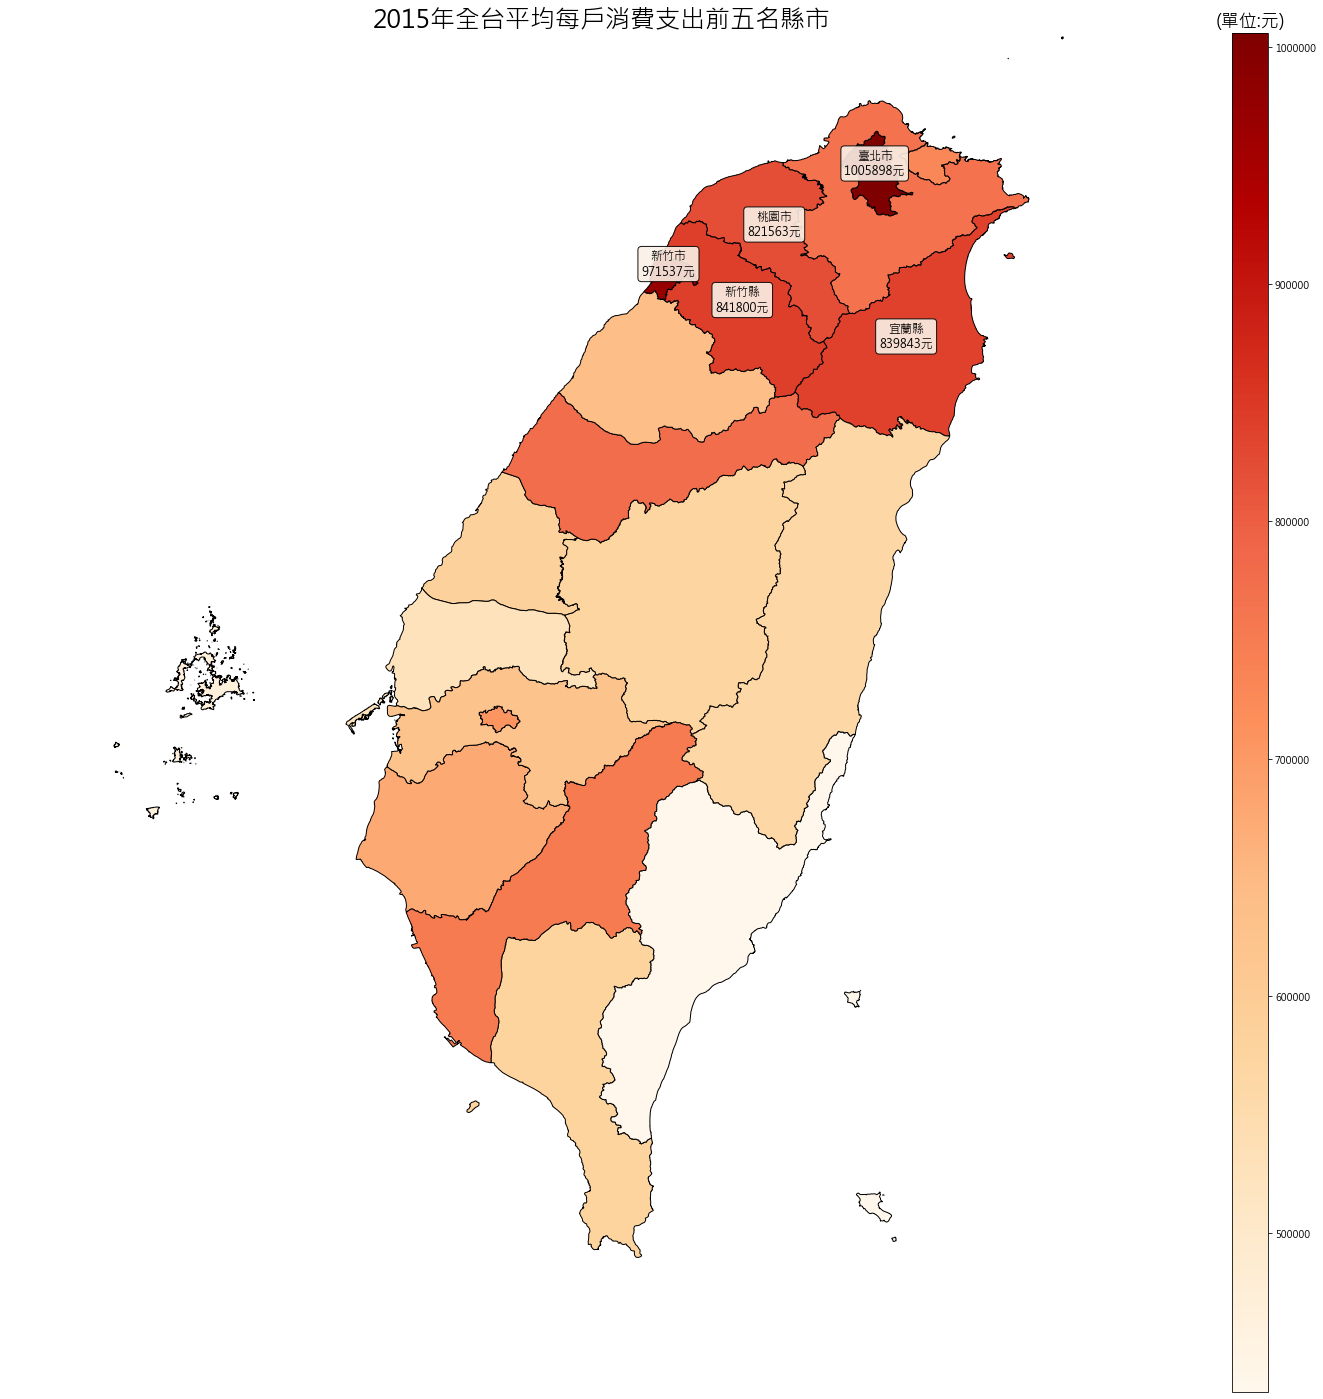

In [5]:
consumption_map('2015')